


# Chemical Solubility prediction by NN


  -Since the dataset is not linearly separable, the logistic regression algorithm is not suggested for the data. Here we implemented an normal neural network(NN) method.The general methodology is referenced by the tutorial codes.

  -picture of NN presentation and fomulas here

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).

<font color=black size=3 face="aria">  </font>



# 1 - Load_chemicals

- The chemicals are incoded in SMILES based on ECFP4
- These functions to load the chemicals for a deep neural network for chemicals' solubility classification.

**After this segment you will be able to:**
- The chemical structure is in SMILES format.
- Get a panda.dataframe of chemical names, solubility and SMILES.


In [32]:
""" Import_packages"""
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from sklearn.cross_validation import train_test_split
import numpy as np
from scipy.stats import norm
import time
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import csv
from synbioTools import tensorChem

In [2]:
""" Read csv file and return it as a panda dataframe(dictionary) """
def read_csv(path):
    """ Read csv, return a panda dataframe(dictionary) """
    df = pd.read_csv(path)
    return df


In [3]:
"""Load chemicals information and convert the chemical info to SMILES format """
def load_chemicals(path):
    
    SolubilityData = read_csv(path) # read csv
    
    chems=[] # variable to store the 
    
#     print("List loaded:\n") # view the list
#     print(SolubilityData)
    
    # change column names of 
    SolubilityData.rename(columns={ SolubilityData.columns[1]: "Solubility" }, inplace=True)
    SolubilityData.rename(columns={ SolubilityData.columns[0]: "Compound" }, inplace=True)
    SolubilityData.rename(columns={ SolubilityData.columns[2]: "SMILES" }, inplace=True)
    
    for row in range(0,len(SolubilityData['SMILES'])):
        chems.append( Chem.MolFromSmiles(SolubilityData['SMILES'][row] ) )
    SolubilityData['SMILES'] = chems
    return SolubilityData # return the data list which contains the three input

#     chems = SolubilityData['SMILES'] # read columns
#     compounds =  SolubilityData['Compound ID']
#     solubilities = SolubilityData['measured log(solubility:mol/L)']
    
#     data = {"chems": chems,
#             "compounds": compounds,
#             "solubilities": solubilities,


data = load_chemicals("C:/Users/DR/Desktop/P2/Latent-master/data/solubility/delaney.csv")

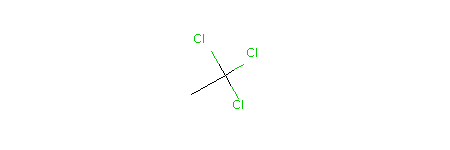

In [4]:
"""Visualize chemical in SMILES format"""
data['SMILES'][1]

# 2 - Convert SMILES into fingerprint

- The chemicals are incoded in SMILES based on ECFP4
- These functions to convert chemicals in SMILES format to fingerprints

**After this segment you will be able to:**
- The chemical structure is in fingerprint binary vector.
- Use rdkit to calculate the fingerprint and map into a binary vector.
- Flatten the vector into a two-dimention binary vector as a tensor.


**Imported RDKFingerprint function from Chem:**

Function: Returns an RDKit topological fingerprint for a molecule

ARGUMENTS for RDKFingerprint:
    
        - mol: the molecule to use
    
        - minPath: (optional) minimum number of bonds to include in the subgraphs
          Defaults to 1.
    
        - maxPath: (optional) maximum number of bonds to include in the subgraphs
          Defaults to 7.
    
        - fpSize: (optional) number of bits in the fingerprint
          Defaults to 2048.
          


In [10]:
"""Fingerprints in different depth: see how max and min depth affect the SMILES binary vector"""
pix=AllChem.RDKFingerprint(data['SMILES'][11], 1, 1, fpSize=20)
fpix = [int(x) for x in list(pix.ToBitString())]
print(fpix)
fpix=AllChem.RDKFingerprint(data['SMILES'][11], 5, 5, fpSize=20)
fpix = [int(x) for x in list(pix.ToBitString())]
print(fpix)

[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


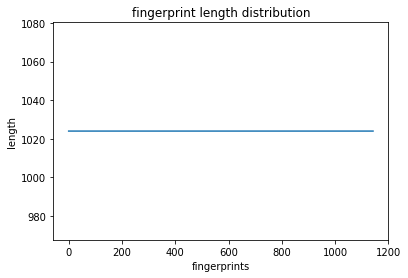

In [13]:
"""Convert SMILES into fingerprint
def chemFP(chem, FINGERPRINT_SIZE, MIN_PATH, MAX_PATH):
    tmp=[]
    length=[]
    fpix=AllChem.RDKFingerprint(chem[0], minPath=MIN_PATH, maxPath=MAX_PATH, fpSize=FINGERPRINT_SIZE)
    fpix = [int(x) for x in list(fpix.ToBitString())]
    for i in range(1,len(chem)):
        tmp = AllChem.RDKFingerprint(chem[i], minPath=MIN_PATH, maxPath=MAX_PATH, fpSize=FINGERPRINT_SIZE) # convert SMILE to fingerprint    
        tmp = [int(x) for x in list(tmp.ToBitString())] # convert footprint object to binary vector
        length.append(len(tmp)) # append length of each fingerprint
        fpix=np.vstack((fpix,tmp)) # stack each fingerprint
    return length,fpix

# Test the function
minPath = 1 
maxPath = 5
fpSize = 1024
length,px = chemFP(data['SMILES'], fpSize, minPath, maxPath)

# plot the fingerprint length distribution
plt.plot(np.squeeze(length))
plt.ylabel('length')
plt.xlabel('fingerprints')
plt.title("fingerprint length distribution" )
plt.show()"""

In [14]:
"""Convert SMILES into fingerprint"""
def chemFP(chem, FINGERPRINT_SIZE, MIN_PATH=1, MAX_PATH=5):
    fpix = AllChem.RDKFingerprint(chem, minPath=MIN_PATH, maxPath=MAX_PATH, fpSize=FINGERPRINT_SIZE)    
    fpix = [int(x) for x in list(fpix.ToBitString())]
    return fpix

In [20]:
""" Encode a chemical as a tensor by concatenating fingerprints up to desired depth """
def tensorChem(chems, FINGERPRINT_SIZE, CHEMDEPTH):
    TRAIN_BATCH_SIZE = len(chems)   
    Xs = np.zeros( (TRAIN_BATCH_SIZE, FINGERPRINT_SIZE, CHEMDEPTH) )
    # print(Xs.shape)
    for i in range(0, len(chems)-1):
        for k in range(0, CHEMDEPTH):
            fpix = chemFP(chems[i],FINGERPRINT_SIZE, k+1, k+1)
            Xs[i, :, k] = fpix
    return Xs


In [21]:
""" Flatten the tensor into a two dimentional vector(feature mapping) """
# The original vector shape
depth = 4
train_y_b4=np.zeros((1,len(data['Solubility'])))
fpSize = 1024
tc = tensorChem(data['SMILES'],fpSize, depth)
print('The original vector shape:\n'+str(tc.shape))
# The flattened vector shape
train_x_flatten = tc.reshape(tc.shape[0], -1).T
print('The flattened vector shape:\n '+str(train_x_flatten.shape))
# The shape of label vector
train_y_b4[0]=np.squeeze(data['Solubility'])
print('The solubility vector shape:\n '+str(train_y_b4.shape))


The original vector shape:
(1144, 1024, 4)
The flattened vector shape:
 (4096, 1144)
The solubility vector shape:
 (1, 1144)


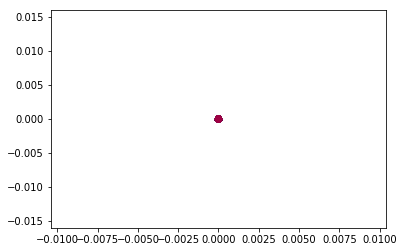

In [83]:
# Visualize the data:
plt.scatter(train_x_flatten[0],train_x_flatten[1], c=train_y[0], s=40, cmap=plt.cm.Spectral);
# Here we should add PCA#####################################################
"""This dataset is a little noisy, but it looks like a diagonal line separating the
upper left half (blue) from the lower right half (red) would work well."""

Text(0,0.5,'fingerprint')

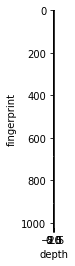

In [82]:
""" Visualize tensor vector """
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(tc[0,:,:])
plt.set_cmap('hot')
plt.xlabel('depth')
plt.ylabel('fingerprint')

# 3 - Label Standarlization

- The solubility are measured as log(solubility:mol/L)
- These functions aim at feature scaling and mean normalize the solubility.

**After this segment you will be able to:**
- Find a threshold of the solubility.
- Chemical solubility prediction can be considered a binary classification task where a classifier should discriminate between soluble chemicals (positive samples) and insoluble chemicals (negative samples). The boudary of the two classes is a specific value of solubility.


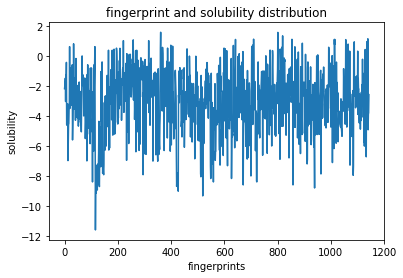

In [25]:
""" Visualize solubility """
# plot the solubility distribution
plt.plot(np.squeeze(train_y_b4))
plt.ylabel('solubility')
plt.xlabel('fingerprints')
plt.title("fingerprint and solubility distribution" )
plt.show()

The mean of the solubility is: -3.0579973776223777
The S.D. of the solubility is: 2.0955854254462576


C:\Users\DR\Anaconda3\envs\my-rdkit-env\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


'In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function \nof a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population\nare made, based on a finite data sample.'

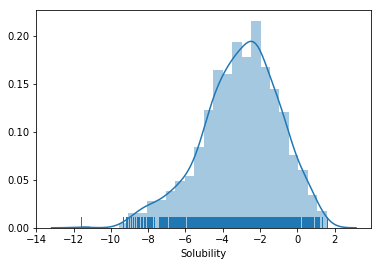

In [45]:
# plot the histogram of solubility
import seaborn as sns
train_y_plot = pd.Series( np.squeeze(train_y_b4), name="Solubility")
mean = train_y_b4.mean()
std = train_y_b4.std()
print("The mean of the solubility is: " + str(mean))
print("The S.D. of the solubility is: " + str(std))
sns.distplot(train_y_plot, kde=True, rug=True, hist=True)
"""In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function 
of a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population
are made, based on a finite data sample."""

There are 606 soluble chemicals (positive samples) and 538 insoluble chemicals (negative samples).


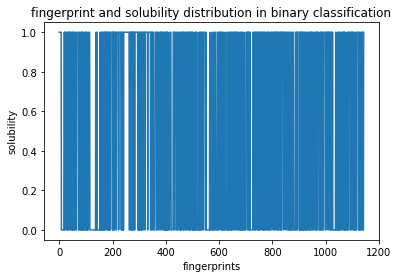

In [57]:
# convert train_y into a vector range from 0 to 1
train_y=np.zeros((1,len(data['Solubility'])))
for i in range(0,len(train_y_b4[0])):
    if (train_y_b4[0][i] >=mean):
        train_y[0][i]=1
    else:
        train_y[0][i]=0

print('There are '+ str(list(np.squeeze(train_y)).count(1)) + ' soluble chemicals (positive samples) and ' + str(list(np.squeeze(train_y)).count(0)) + ' insoluble chemicals (negative samples).')
        
# plot the input fingerprint length distribution plot
plt.plot(np.squeeze(train_y))
plt.ylabel('solubility')
plt.xlabel('fingerprints')
plt.title("fingerprint and solubility distribution in binary classification" )
plt.show()


###  L-Layer NN Model 

**After this segment you will be able to:**
- Use non-linear units like ReLU to improve your model
- Build a deeper neural network (with more than 1 hidden layer)
- Implement an easy-to-use neural network class

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).

<font color=black size=3 face="aria">  </font>

Codes based on Andrew N.g's model code

Implementing the $L$-layer Neural Net, we design a function that replicates(`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. We have provided you with the `sigmoid` function. This function returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. We have provided you with the `relu` function. This function returns **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call:
``` python
A, activation_cache = relu(Z)




**Steps**:
- Use the functions you had previously written 
- Use a for loop to replicate [LINEAR->RELU] (L-1) times
- Don't forget to keep track of the caches in the "caches" list. To add a new value `c` to a `list`, you can use `list.append(c)`.

In [154]:
"""Define activation functions"""

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ
def dictionary_to_vector(parameters):
    """
    Roll all our parameters dictionary into a single vector satisfying our specific required shape.
    """
    keys = []
    count = 0
    for key in ["W1", "b1", "W2", "b2", "W3", "b3"]:
        
        # flatten parameter
        new_vector = np.reshape(parameters[key], (-1,1))
        keys = keys + [key]*new_vector.shape[0]
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta, keys

def vector_to_dictionary(theta):
    """
    Unroll all our parameters dictionary from a single vector satisfying our specific required shape.
    """
    parameters = {}
    parameters["W1"] = theta[:20].reshape((5,4))
    parameters["b1"] = theta[20:25].reshape((5,1))
    parameters["W2"] = theta[25:40].reshape((3,5))
    parameters["b2"] = theta[40:43].reshape((3,1))
    parameters["W3"] = theta[43:46].reshape((1,3))
    parameters["b3"] = theta[46:47].reshape((1,1))

    return parameters

def gradients_to_vector(gradients):
    """
    Roll all our gradients dictionary into a single vector satisfying our specific required shape.
    """
    
    count = 0
    for key in ["dW1", "db1", "dW2", "db2", "dW3", "db3"]:
        # flatten parameter
        new_vector = np.reshape(gradients[key], (-1,1))
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta

## 1 - He initialization

"He Initialization" is named for the first author of He et al., 2015. (If you have heard of "Xavier initialization", this is similar except Xavier initialization uses a scaling factor for the weights $W^{[l]}$ of `sqrt(1./layers_dims[l-1])` where He initialization would use `sqrt(2./layers_dims[l-1])`.)


**Hint**: This function is similar to the previous `initialize_parameters_random(...)`. The only difference is that instead of multiplying `np.random.randn(..,..)` by 10, you will multiply it by $\sqrt{\frac{2}{\text{dimension of the previous layer}}}$, which is what He initialization recommends for layers with a ReLU activation. 

In [59]:
"""Init_parameters_he""" 
def initialize_parameters_he(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
     
    for l in range(1, L + 1):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2 / layers_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        ### END CODE HERE ###
        
    return parameters

## 2 - Forward propagation module

### 2.1 - Linear Forward 
Now that you have initialized your parameters, you will do the forward propagation module. You will start by implementing some basic functions that you will use later when implementing the model. You will complete three functions in this order:

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 

**Exercise**: Build the linear part of forward propagation.

**Reminder**:
The mathematical representation of this unit is $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$. You may also find `np.dot()` useful. If your dimensions don't match, printing `W.shape` may help.

In [129]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W,A)+b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

### 2.2 - Linear-Activation Forward

In this notebook, you will use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. We have provided you with the `sigmoid` function. This function returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. We have provided you with the `relu` function. This function returns **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call:
``` python
A, activation_cache = relu(Z)
```

In [130]:
def linear_activation_forward(A_prev, W, b, activation,keep_prob=1):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
        ### END CODE HERE ###
        Dt = np.random.rand(A.shape[0], A.shape[1])
        
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)
        # Dropout
        Dt = np.random.rand(A.shape[0], A.shape[1])                                         # Step 1: initialize matrix D2 = np.random.rand(..., ...)
        Dt = Dt < keep_prob                                         # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
        A = A * Dt                                         # Step 3: shut down some neurons of A2
        A = A / keep_prob     
        ### END CODE HERE ###
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache,Dt)

    return A, cache

### 2.3 -  L-Layer Model Forward

For even more convenience when implementing the $L$-layer Neural Net, you will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.


**Instruction**: In the code below, the variable `AL` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.) 

**Tips**:
- Use the functions you had previously written 
- Use a for loop to replicate [LINEAR->RELU] (L-1) times
- Don't forget to keep track of the caches in the "caches" list. To add a new value `c` to a `list`, you can use `list.append(c)`.

In [131]:
def L_model_forward(X, parameters, keep_prob):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_he()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """
    
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    keep_probtmp=keep_prob
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        
        ### START CODE HERE ### (≈ 2 lines of code)
        A, cache = linear_activation_forward(A_prev,parameters['W'+str(l)], parameters['b'+str(l)], activation='relu',keep_prob=keep_probtmp)
        caches.append(cache)
        ### END CODE HERE ###
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    ### START CODE HERE ### (≈ 2 lines of code)
    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], activation='sigmoid')
    caches.append(cache)
    ### END CODE HERE ###
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

## 3 - Cost function

**Compute the cross-entropy cost $J$, using the following formula:** $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [70]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    cost = (-1/m)*np.sum(np.multiply(Y,np.log(AL))+np.multiply(1-Y,np.log(1-AL)))
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

def compute_cost_with_regularization(AL, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    L2 =0
    for i in range(1,len(AL)):
        L2 = L2 + lambd * (np.sum( parameters['W'+str(i)]) ) / (2 * m)
    cross_entropy_cost = compute_cost(AL, Y) # This gives you the cross-entropy part of the cost
    
    ### START CODE HERE ### (approx. 1 line)
    L2_regularization_cost = (-1/m)*np.sum(np.multiply(Y,np.log(AL))+np.multiply(1-Y,np.log(1-AL))) + L2
    ### END CODER HERE ###
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

## 4 - Backward propagation module

Just like with forward propagation, you will implement helper functions for backpropagation. Remember that back propagation is used to calculate the gradient of the loss function with respect to the parameters. 

**Reminder**: 

<!-- 
For those of you who are expert in calculus (you don't need to be to do this assignment), the chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, you use the previous chain rule and you do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During the backpropagation, at each step you multiply your current gradient by the gradient corresponding to the specific layer to get the gradient you wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, you use the previous chain rule and you do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

This is why we talk about **backpropagation**.
!-->

Now, similar to forward propagation, you are going to build the backward propagation in three steps:
- LINEAR backward
- LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

### 4.1 - Linear backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]} dA^{[l-1]})$.


The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l]})$ are computed using the input $dZ^{[l]}$.Here are the formulas you need:
$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


In [150]:
def linear_backward(dZ, cache,keep_prob,D):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    dW = (1/m)*np.dot(dZ,cache[0].T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(cache[1].T,dZ)
    if keep_prob<1:
        dA_prev = dA_prev * D                # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
        dA_prev = dA_prev / keep_prob 
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

# FUNCTION: backward_propagation_with_regularization

def backward_propagation_with_regularization(dZ, cache, lambd,keep_prob,D):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    dW = (1/m)*np.dot(dZ,cache[0].T) + (lambd * W) / m
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(cache[1].T,dZ)
    if keep_prob<1:
        dA_prev = dA_prev * D                # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
        dA_prev = dA_prev / keep_prob              # Step 2: Scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

    ### START CODE HERE ### (approx. 1 line)

### 4.2 - Linear-Activation backward

Next, you will create a function that merges the two helper functions: **`linear_backward`** and the backward step for the activation **`linear_activation_backward`**. 

To help you implement `linear_activation_backward`, we provided two backward functions:
- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit. You can call it as follows:

```python
dZ = sigmoid_backward(dA, activation_cache)
```

- **`relu_backward`**: Implements the backward propagation for RELU unit. You can call it as follows:

```python
dZ = relu_backward(dA, activation_cache)
```

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{11}$$.  

**Exercise**: Implement the backpropagation for the *LINEAR->ACTIVATION* layer.

In [140]:
def linear_activation_backward(dA, cache, activation, regu,lambd,keep_prob):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache, D = cache
    
    if activation == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        if regu == True:
            dZ = relu_backward(dA,activation_cache)
            dA_prev, dW, db = backward_propagation_with_regularization(dZ,linear_cache,lambd,keep_prob,D)
        else:
            dZ = relu_backward(dA,activation_cache)
            dA_prev, dW, db = linear_backward(dZ,linear_cache,keep_prob,D)
        ### END CODE HERE ###
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA,activation_cache)
        if regu == True:
            dA_prev, dW, db = backward_propagation_with_regularization(dZ,linear_cache,lambd,keep_prob,D)
        else:
            dA_prev, dW, db = linear_backward(dZ,linear_cache,keep_prob,D)
        ### END CODE HERE ###
    
    return dA_prev, dW, db

### 4.3 - L-Model Backward 

Now you will implement the backward function for the whole network. Recall that when you implemented the `L_model_forward` function, at each iteration, you stored a cache which contains (X,W,b, and z). In the back propagation module, you will use those variables to compute the gradients. Therefore, in the `L_model_backward` function, you will iterate through all the hidden layers backward, starting from layer $L$. On each step, you will use the cached values for layer $l$ to backpropagate through layer $l$. Figure 5 below shows the backward pass. 



** Initializing backpropagation**:
To backpropagate through this network, we know that the output is, 
$A^{[L]} = \sigma(Z^{[L]})$. Your code thus needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, use this formula (derived using calculus which you don't need in-depth knowledge of):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

You can then use this post-activation gradient `dAL` to keep going backward. As seen in Figure 5, you can now feed in `dAL` into the LINEAR->SIGMOID backward function you implemented (which will use the cached values stored by the L_model_forward function). After that, you will have to use a `for` loop to iterate through all the other layers using the LINEAR->RELU backward function. You should store each dA, dW, and db in the grads dictionary. To do so, use this formula : 

$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$

For example, for $l=3$ this would store $dW^{[l]}$ in `grads["dW3"]`.

**Exercise**: Implement backpropagation for the *[LINEAR->RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model.

In [152]:
def L_model_backward(AL, Y, caches, regu,lambd,keep_prob):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if right, 1 if opposive)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[L-1]
    if regu == True:
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,current_cache,'sigmoid',True,lambd,keep_prob)
    else:
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,current_cache,'sigmoid',False,lambd,keep_prob)
    
    ### END CODE HERE ###
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        if regu == True:
            dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu",True,lambd,keep_prob)
        else:
            dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu",False,lambd,keep_prob)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

### 4.4 - Update Parameters

In this section you will update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. After computing the updated parameters, store them in the parameters dictionary. 

In [88]:
"""update vectors W,b for gradient descent"""

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
     
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads["db"+str(l+1)]
    ### END CODE HERE ###
    return parameters

# 5 - Main model

In [157]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = True, lambd = 0, keep_prob = 1,grad_check=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []                         # keep track of cost
    lambdtmp = lambd
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_he(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        if keep_prob == 1:
            AL, caches = L_model_forward(X,parameters,keep_prob)
        elif keep_prob < 1:
            AL, caches = L_model_forward(X,parameters,keep_prob)
        
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        if lambd == 0:
            cost = compute_cost(AL,Y)
        else:
            cost = compute_cost_with_regularization(AL, Y, parameters, lambd)
            
        
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)  
        if lambd == 0 and keep_prob == 1:
            grads = L_model_backward(AL,Y,caches,False,lambd,keep_prob)
        elif lambd != 0:
            grads = L_model_backward(AL,Y,caches,True,lambd,keep_prob)
        elif keep_prob < 1:
            grads = L_model_backward(AL,Y,caches,False,lambd,keep_prob)
        ### END CODE HERE ###
        # difference = gradient_check_n(parameters, grads, X, Y)
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters,grads,learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            if grad_check==True:
                print ("Difference after iteration %i: %f" %(i, difference))
        if  i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters,costs

#  Application

- In the segment, we will used the deep NN to train a model from the chemicals data
- In the next assignment, you will use these functions to build a deep neural network for solubility classification.

**After this assignment you will be able to:**

- Train a solubility classifier from chemicles(binary vector) and relervant solubility data
- Implement an easy-to-use classifier

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).

<font color=black size=3 face="aria">  </font>

train_x_flatten: the binary vector of a chemicals list

train_y: the solubility feature of the vector


## Cross validation
**train set/dev set/test set = 90/10/10 (dev=test)**

3-fold cross-validation based on K-fold
If we have smaller data it can be useful to benefit from k-fold cross-validation to maximize our ability to evaluate the neural network’s performance. This is possible in Keras because we can “wrap” any neural network such that it can use the evaluation features available in scikit-learn, including k-fold cross-validation. To accomplish this, we first have to create a function that returns a compiled neural network. Next we use KerasClassifier (if we have a classifier, if we have a regressor we can use KerasRegressor) to wrap the model so it can be used by scikit-learn. After this, we can use our neural network like any other scikit-learn learning algorithm (e.g. random forests, logistic regression). In our solution, we used cross_val_score to run a 3-fold cross-validation on our neural network.

In [59]:
"""The train_set_split function from sklearn can only accepted dataset in shape(samples,features)"""
train_yy=train_y.T
train_xx=train_x_flatten.T

In [60]:
"""Split the data in train/test = 0.9/0.1"""
X_train, X_test, y_train, y_test = train_test_split(train_xx, train_yy, test_size=0.10)

In [61]:
X_train=X_train.T
X_test=X_test.T
y_train=y_train.T
y_test=y_test.T

Cost after iteration 0: 0.715482
Cost after iteration 100: 0.687310
Cost after iteration 200: 0.670816
Cost after iteration 300: 0.646592
Cost after iteration 400: 0.617939
Cost after iteration 500: 0.583520
Cost after iteration 600: 0.545674
Cost after iteration 700: 0.505374
Cost after iteration 800: 0.464710
Cost after iteration 900: 0.424942
Cost after iteration 1000: 0.385136
Cost after iteration 1100: 0.346119
Cost after iteration 1200: 0.308686
Cost after iteration 1300: 0.274407
Cost after iteration 1400: 0.244842
Cost after iteration 1500: 0.220389
Cost after iteration 1600: 0.200727
Cost after iteration 1700: 0.184607
Cost after iteration 1800: 0.170917
Cost after iteration 1900: 0.156834
Cost after iteration 2000: 0.144074
Cost after iteration 2100: 0.133255
Cost after iteration 2200: 0.124125
Cost after iteration 2300: 0.116304
Cost after iteration 2400: 0.109525
Cost after iteration 2500: 0.103676
Cost after iteration 2600: 0.098391
Cost after iteration 2700: 0.093093
Cost

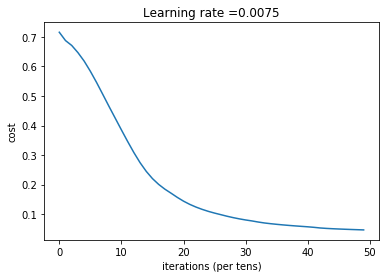

Accuracy 98% on the training set.
Accuracy 84% on the test set.
Cost after iteration 0: 0.710372
Cost after iteration 100: 0.683198
Cost after iteration 200: 0.661510
Cost after iteration 300: 0.637927
Cost after iteration 400: 0.610395
Cost after iteration 500: 0.577908
Cost after iteration 600: 0.541116
Cost after iteration 700: 0.503096
Cost after iteration 800: 0.465995
Cost after iteration 900: 0.430392
Cost after iteration 1000: 0.397210
Cost after iteration 1100: 0.366066
Cost after iteration 1200: 0.336672
Cost after iteration 1300: 0.308392
Cost after iteration 1400: 0.281746
Cost after iteration 1500: 0.256745
Cost after iteration 1600: 0.233863
Cost after iteration 1700: 0.213530
Cost after iteration 1800: 0.195840
Cost after iteration 1900: 0.180789
Cost after iteration 2000: 0.167417
Cost after iteration 2100: 0.155295
Cost after iteration 2200: 0.144285
Cost after iteration 2300: 0.134669
Cost after iteration 2400: 0.126318
Cost after iteration 2500: 0.119565
Cost after i

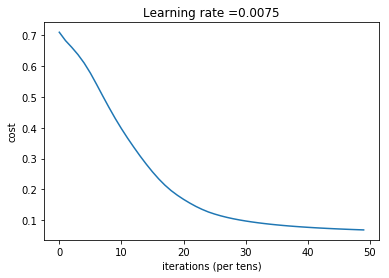

Accuracy 96% on the training set.
Accuracy 78% on the test set.
Cost after iteration 0: 0.713052
Cost after iteration 100: 0.678500
Cost after iteration 200: 0.652552
Cost after iteration 300: 0.624198
Cost after iteration 400: 0.594660
Cost after iteration 500: 0.562301
Cost after iteration 600: 0.527740
Cost after iteration 700: 0.491654
Cost after iteration 800: 0.457350
Cost after iteration 900: 0.425222
Cost after iteration 1000: 0.395964
Cost after iteration 1100: 0.369141
Cost after iteration 1200: 0.343899
Cost after iteration 1300: 0.319716
Cost after iteration 1400: 0.296495
Cost after iteration 1500: 0.274040
Cost after iteration 1600: 0.252680
Cost after iteration 1700: 0.233422
Cost after iteration 1800: 0.216553
Cost after iteration 1900: 0.202051
Cost after iteration 2000: 0.189885
Cost after iteration 2100: 0.179636
Cost after iteration 2200: 0.170439
Cost after iteration 2300: 0.162237
Cost after iteration 2400: 0.155315
Cost after iteration 2500: 0.148954
Cost after i

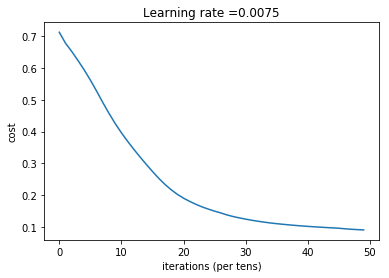

Accuracy 96% on the training set.
Accuracy 78% on the test set.


In [207]:
"""StratifiedKFold"""
from sklearn.model_selection import StratifiedKFold # import KFold
sfolder.get_n_splits(train_xx,train_yy)
sfolder = StratifiedKFold(n_splits=3,random_state=0,shuffle=False)
for train, test in sfolder.split(train_xx,train_yy):
    X_train, X_test = train_xx[train].T, train_xx[test].T
    y_train, y_test = train_yy[train].T, train_yy[test].T
    parameters,costs = L_layer_model(X_train, y_train, layers_dims, learning_rate = 0.0075, num_iterations = 5000, print_cost = True,lambd = 0)
    predictions = predict(parameters, X_train)
    print ('Accuracy %d' % float((np.dot(y_train,predictions.T) + np.dot(1-y_train,1-predictions.T))/float(y_train.size)*100) + '%'+" on the training set.")
    predictions = predict(parameters, X_test)
    print ('Accuracy %d' % float((np.dot(y_test,predictions.T) + np.dot(1-y_test,1-predictions.T))/float(y_test.size)*100) + '%'+" on the test set.")

## 1 - Prediction

**Compute the prediction accuracy of the trained model by the input dataset

In [206]:
"""Prediction based on training set"""
#Should be testing set########

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (non-significant: 0 / significant: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = L_model_forward(X,parameters,keep_prob=1)
    predictions = np.round(A2)
    ### END CODE HERE ###
    
    return predictions

In [63]:
""" Define_NN_structures """
n_x=train_x_flatten.shape[0]    # fpsize  * 4(depth)
n_h = 7 # neurons number of second hidden layer
n_y = 1 # output neuron number

# 4-layer model of neurons as 20,7,5,1 in layers
layers_dims = [n_x, 20, n_h, 5, n_y] 

Cost after iteration 0: 0.712751
Cost after iteration 100: 0.687584
Cost after iteration 200: 0.668987
Cost after iteration 300: 0.649206
Cost after iteration 400: 0.626053
Cost after iteration 500: 0.597945
Cost after iteration 600: 0.566320
Cost after iteration 700: 0.531974
Cost after iteration 800: 0.497501
Cost after iteration 900: 0.464567
Cost after iteration 1000: 0.433047
Cost after iteration 1100: 0.403363
Cost after iteration 1200: 0.375579
Cost after iteration 1300: 0.349050
Cost after iteration 1400: 0.323805
Cost after iteration 1500: 0.299832
Cost after iteration 1600: 0.277246
Cost after iteration 1700: 0.256161
Cost after iteration 1800: 0.237371
Cost after iteration 1900: 0.220969
Cost after iteration 2000: 0.206910
Cost after iteration 2100: 0.194713
Cost after iteration 2200: 0.184274
Cost after iteration 2300: 0.174595
Cost after iteration 2400: 0.164995
Cost after iteration 2500: 0.156428
Cost after iteration 2600: 0.149201
Cost after iteration 2700: 0.142913
Cost

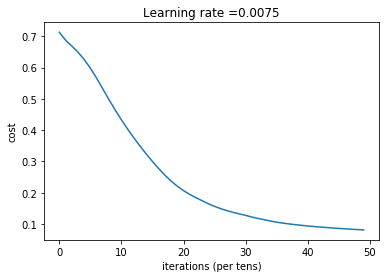

In [158]:
"""Train the model"""
parameters,costs = L_layer_model(X_train, y_train, layers_dims, learning_rate = 0.0075, num_iterations = 5000, print_cost = True,lambd = 0)

In [68]:
# Print accuracy
predictions = predict(parameters, X_train)
print ('Accuracy %d' % float((np.dot(y_train,predictions.T) + np.dot(1-y_train,1-predictions.T))/float(y_train.size)*100) + '%'+" on the training set.")
predictions = predict(parameters, X_test)
print ('Accuracy %d' % float((np.dot(y_test,predictions.T) + np.dot(1-y_test,1-predictions.T))/float(y_test.size)*100) + '%'+" on the test set.")

Accuracy 96% on the training set.
Accuracy 87% on the test set.


##  3 - L2 Regularization

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$


```
Note that you have to do this for $W^{[1]}$, $W^{[2]}$ and $W^{[3]}$, then sum the three terms and multiply by $ \frac{1}{m} \frac{\lambda}{2} $.

Cost after iteration 0: 1.425503
Cost after iteration 100: 0.394658
Cost after iteration 200: 0.204186
Cost after iteration 300: 0.153697
Cost after iteration 400: 0.134807
Cost after iteration 500: 0.130089
Cost after iteration 600: 0.129017
Cost after iteration 700: 0.127463
Cost after iteration 800: 0.126845
Cost after iteration 900: 0.122930
Cost after iteration 1000: 0.119913
Cost after iteration 1100: 0.117771
Cost after iteration 1200: 0.116821
Cost after iteration 1300: 0.117262
Cost after iteration 1400: 0.116762
Cost after iteration 1500: 0.115236
Cost after iteration 1600: 0.114804
Cost after iteration 1700: 0.117469
Cost after iteration 1800: 0.117922
Cost after iteration 1900: 0.114621
Cost after iteration 2000: 0.113891
Cost after iteration 2100: 0.118013
Cost after iteration 2200: 0.116089
Cost after iteration 2300: 0.114163
Cost after iteration 2400: 0.114680
Cost after iteration 2500: 0.116781
Cost after iteration 2600: 0.116483
Cost after iteration 2700: 0.113563
Cost

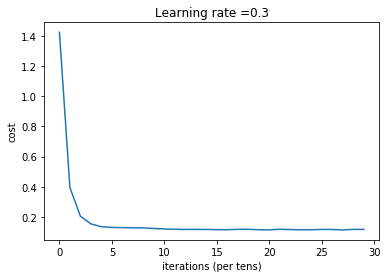

Accuracy: 96% on the training set:
Accuracy: 83% on the test set:


In [94]:
"""Train the model after regularization"""
parameters,costs = L_layer_model(X_train, y_train, layers_dims, learning_rate = 0.3, num_iterations = 3000, print_cost = True,lambd = 0.5)
# Print accuracy
predictions = predict(parameters, X_train)
print ('Accuracy: %d' % float((np.dot(y_train,predictions.T) + np.dot(1-y_train,1-predictions.T))/float(y_train.size)*100) + '%'+" on the training set:")
predictions = predict(parameters, X_test)
print ('Accuracy: %d' % float((np.dot(y_test,predictions.T) + np.dot(1-y_test,1-predictions.T))/float(y_test.size)*100) + '%'+" on the test set:")

In [ ]:
# """ plot the decision boundary of your trained model to see if there is over-fitting"""
# plt.title("Model without regularization")
# axes = plt.gca()
# axes.set_xlim([-0.75,0.40])
# axes.set_ylim([-0.75,0.65])
# plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 4 - Dropout neurons

**Inverted dropout**

When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 

Cost after iteration 0: 0.712751
Cost after iteration 100: 0.435126
Cost after iteration 200: 0.228246
Cost after iteration 300: 0.147462
Cost after iteration 400: 0.112145
Cost after iteration 500: 0.090940
Cost after iteration 600: 0.087004
Cost after iteration 700: 0.078980
Cost after iteration 800: 0.074457
Cost after iteration 900: 0.073319
Cost after iteration 1000: 0.070229
Cost after iteration 1100: 0.070289
Cost after iteration 1200: 0.068141
Cost after iteration 1300: 0.066317


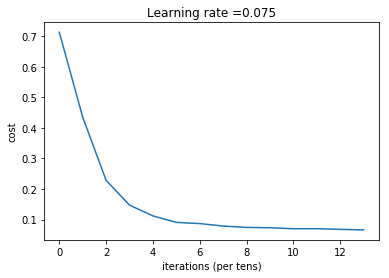

In [98]:
"""Train the model after regularization"""
parameters,costs = L_layer_model(X_train, y_train, layers_dims, learning_rate = 0.075, num_iterations = 1400, print_cost = True,lambd = 0,keep_prob=0.7)

In [99]:
# Print accuracy
predictions = predict(parameters, X_train)
print ('Accuracy: %d' % float((np.dot(y_train,predictions.T) + np.dot(1-y_train,1-predictions.T))/float(y_train.size)*100) + '%'+" on the training set:")
predictions = predict(parameters, X_test)
print ('Accuracy: %d' % float((np.dot(y_test,predictions.T) + np.dot(1-y_test,1-predictions.T))/float(y_test.size)*100) + '%'+" on the test set:")

Accuracy: 96% on the training set:
Accuracy: 84% on the test set:


# Additional: Tunning hidden layer size in 2nd hidden layer 

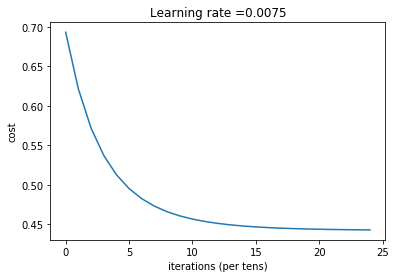

Accuracy for 1 hidden units: 83.82867132867133 %


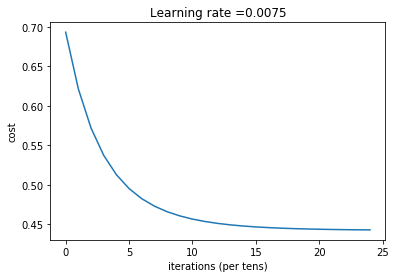

Accuracy for 2 hidden units: 83.82867132867133 %


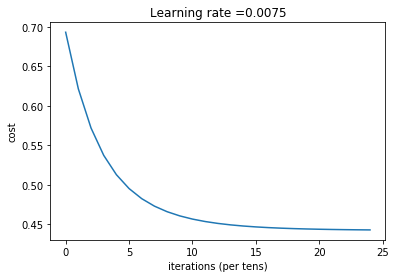

Accuracy for 3 hidden units: 83.82867132867133 %


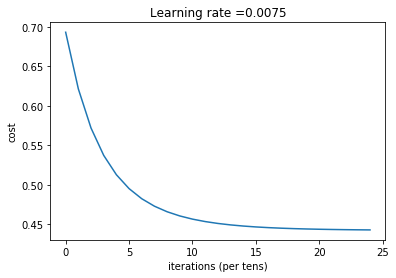

Accuracy for 4 hidden units: 83.82867132867133 %


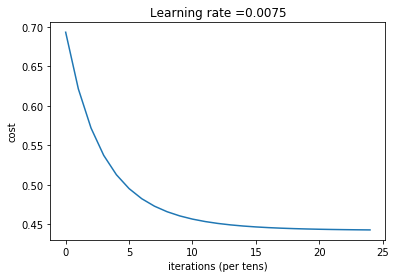

Accuracy for 5 hidden units: 83.82867132867133 %


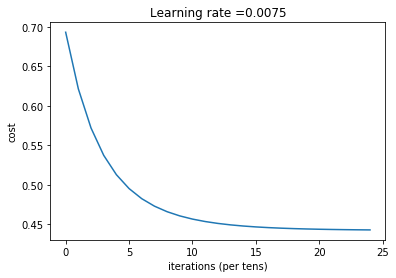

Accuracy for 20 hidden units: 83.82867132867133 %


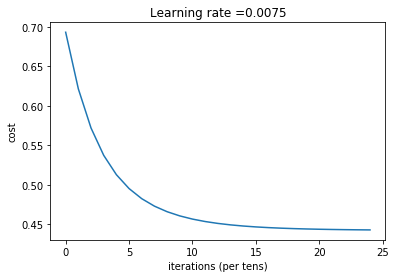

Accuracy for 50 hidden units: 83.82867132867133 %


In [107]:
# Tunning hidden layer size in hidden layer 2nd

hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]

costs=[]

for i, n_h in enumerate(hidden_layer_sizes):
    layers_dims = [n_x, 20, n_h, 5, n_y] #  4-layers model with n_h hidden units
    parameters,costs = L_layer_model(train_x_flatten, train_y, layers_dims, num_iterations = 2500, print_cost = False)

    # Here we should add PCA#####################################################
    #plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters,train_x_flatten)
    accuracy = float((np.dot(train_y,predictions.T) + np.dot(1-train_y,1-predictions.T))/float(train_y.size)*100) 
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

# Tuning learning rate

learning rate is: 0.01


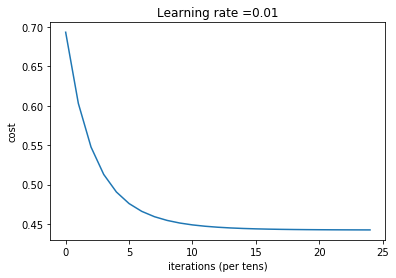

Time for learning rate0.01 : 130.51328468322754 %
Accuracy for learning rate0.01 : 83.82867132867133 %

-------------------------------------------------------

learning rate is: 0.001


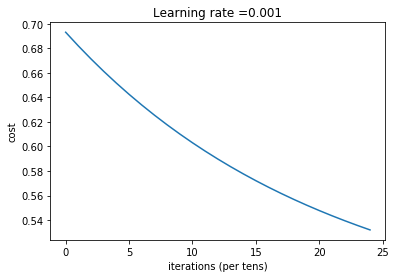

Time for learning rate0.001 : 133.12642455101013 %
Accuracy for learning rate0.001 : 83.82867132867133 %

-------------------------------------------------------



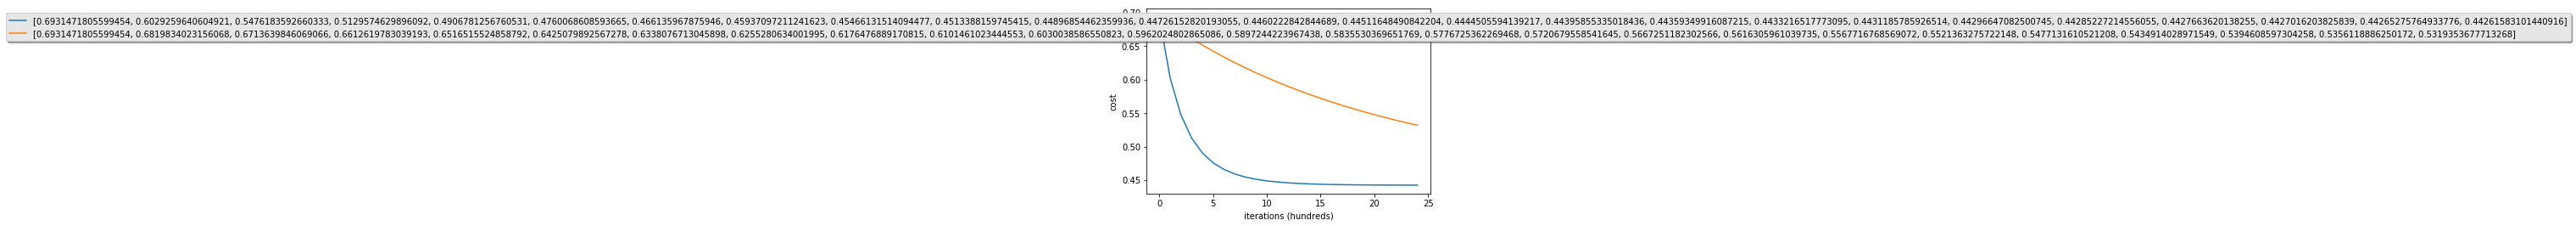

In [120]:
"""Tuning learning rate"""
#Try PyTOUCH########################################
learning_rates = [0.01, 0.001, 0.0001]
layers_dims = [n_x, 20, 1, 1, n_y]
costs_list=[]
for i in range(0,len(learning_rates)-1):
    print ("learning rate is: " + str(learning_rates[i]))
    start = time.time()
    parameters,costs = L_layer_model(train_x_flatten, train_y, layers_dims,learning_rate=learning_rates[i], num_iterations = 2500, print_cost = False)
    elapsed = (time.time() - start)
    print ("Time for learning rate{} : {} %".format(str(learning_rates[i]), elapsed))
    costs_list.append(costs)
    predictions = predict(parameters,train_x_flatten)
    accuracy = float((np.dot(train_y,predictions.T) + np.dot(1-train_y,1-predictions.T))/float(train_y.size)*100) 
    print ("Accuracy for learning rate{} : {} %".format(str(learning_rates[i]), accuracy))
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in range(0,len(learning_rates)-1):
    plt.plot(np.squeeze(costs_list[i]), label= str(costs_list[i]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

##  Gradient checking 

Backpropagation computes the gradients $\frac{\partial J}{\partial \theta}$, where $\theta$ denotes the parameters of the model. $J$ is computed using forward propagation and your loss function.

Because forward propagation is relatively easy to implement, you're confident you got that right, and so you're almost  100% sure that you're computing the cost $J$ correctly. Thus, you can use your code for computing $J$ to verify the code for computing $\frac{\partial J}{\partial \theta}$. 

Let's look back at the definition of a derivative (or gradient):
$$ \frac{\partial J}{\partial \theta} = \lim_{\varepsilon \to 0} \frac{J(\theta + \varepsilon) - J(\theta - \varepsilon)}{2 \varepsilon} \tag{1}$$

If you're not familiar with the "$\displaystyle \lim_{\varepsilon \to 0}$" notation, it's just a way of saying "when $\varepsilon$ is really really small."

We know the following:

- $\frac{\partial J}{\partial \theta}$ is what you want to make sure you're computing correctly. 
- You can compute $J(\theta + \varepsilon)$ and $J(\theta - \varepsilon)$ (in the case that $\theta$ is a real number), since you're confident your implementation for $J$ is correct. 

**How does gradient checking work?**.

As in 1) and 2), you want to compare "gradapprox" to the gradient computed by backpropagation. The formula is still:

$$ \frac{\partial J}{\partial \theta} = \lim_{\varepsilon \to 0} \frac{J(\theta + \varepsilon) - J(\theta - \varepsilon)}{2 \varepsilon} \tag{1}$$

However, $\theta$ is not a scalar anymore. It is a dictionary called "parameters". We implemented a function "`dictionary_to_vector()`" for you. It converts the "parameters" dictionary into a vector called "values", obtained by reshaping all parameters (W1, b1, W2, b2, W3, b3) into vectors and concatenating them.

The inverse function is "`vector_to_dictionary`" which outputs back the "parameters" dictionary.


We have also converted the "gradients" dictionary into a vector "grad" using gradients_to_vector(). You don't need to worry about that.

**Exercise**: Implement gradient_check_n().

**Instructions**: Here is pseudo-code that will help you implement the gradient check.

For each i in num_parameters:
- To compute `J_plus[i]`:
    1. Set $\theta^{+}$ to `np.copy(parameters_values)`
    2. Set $\theta^{+}_i$ to $\theta^{+}_i + \varepsilon$
    3. Calculate $J^{+}_i$ using to `forward_propagation_n(x, y, vector_to_dictionary(`$\theta^{+}$ `))`.     
- To compute `J_minus[i]`: do the same thing with $\theta^{-}$
- Compute $gradapprox[i] = \frac{J^{+}_i - J^{-}_i}{2 \varepsilon}$

Thus, you get a vector gradapprox, where gradapprox[i] is an approximation of the gradient with respect to `parameter_values[i]`. You can now compare this gradapprox vector to the gradients vector from backpropagation. Just like for the 1D case (Steps 1', 2', 3'), compute: 
$$ difference = \frac {\| grad - gradapprox \|_2}{\| grad \|_2 + \| gradapprox \|_2 } \tag{3}$$

In [102]:
# GRADED FUNCTION: gradient_check_n

def gradient_check_n(parameters, gradients, X, Y, epsilon = 1e-7):
    """
    Checks if backward_propagation_n computes correctly the gradient of the cost output by forward_propagation_n
    
    Arguments:
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
    grad -- output of backward_propagation_n, contains gradients of the cost with respect to the parameters. 
    x -- input datapoint, of shape (input size, 1)
    y -- true "label"
    epsilon -- tiny shift to the input to compute approximated gradient with formula(1)
    
    Returns:
    difference -- difference (2) between the approximated gradient and the backward propagation gradient
    """
    
    # Set-up variables
    parameters_values, _ = dictionary_to_vector(parameters)
    grad = gradients_to_vector(gradients)
    num_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))
    
    # Compute gradapprox
    for i in range(num_parameters):
        
        # Compute J_plus[i]. Inputs: "parameters_values, epsilon". Output = "J_plus[i]".
        # "_" is used because the function you have to outputs two parameters but we only care about the first one
        ### START CODE HERE ### (approx. 3 lines)
        thetaplus =np.copy(parameters_values)                                      # Step 1
        thetaplus[i][0] = thetaplus[i][0] + epsilon                                  # Step 2
        J_plus[i], _ =  forward_propagation_n(X, Y, vector_to_dictionary(thetaplus))                                   # Step 3
        ### END CODE HERE ###
        
        # Compute J_minus[i]. Inputs: "parameters_values, epsilon". Output = "J_minus[i]".
        ### START CODE HERE ### (approx. 3 lines)
        thetaminus = np.copy(parameters_values)                                      # Step 1
        thetaminus[i][0] = thetaminus[i][0] - epsilon                               # Step 2        
        J_minus[i], _ = forward_propagation_n(X, Y, vector_to_dictionary(thetaminus))                                  # Step 3
        ### END CODE HERE ###
        
        # Compute gradapprox[i]
        ### START CODE HERE ### (approx. 1 line)
        gradapprox[i] = (J_plus[i] - J_minus[i]) / (2 * epsilon)
        ### END CODE HERE ###
    
    # Compare gradapprox to backward propagation gradients by computing difference.
    ### START CODE HERE ### (approx. 1 line)
    numerator = np.linalg.norm(grad - gradapprox)                                           # Step 1'
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)                                         # Step 2'
    difference = numerator / denominator                                          # Step 3'
    ### END CODE HERE ###

    if difference > 2e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference

In [178]:
"""Train the model after regularization"""
parameters,costs = L_layer_model(X_train, y_train, layers_dims, learning_rate = 0.075, num_iterations = 1400, print_cost = True,lambd = 0,keep_prob=1,grad_check=True)

ValueError: shapes (20,4096) and (3,4096) not aligned: 4096 (dim 1) != 3 (dim 0)

## Keras 
**If we have smaller data it can be useful to benefit from k-fold cross-validation to maximize our ability to evaluate the neural network’s performance. This is possible in Keras because we can “wrap” any neural network such that it can use the evaluation features available in scikit-learn, including k-fold cross-validation. To accomplish this, we first have to create a function that returns a compiled neural network. Next we use KerasClassifier (if we have a classifier, if we have a regressor we can use KerasRegressor) to wrap the model so it can be used by scikit-learn. After this, we can use our neural network like any other scikit-learn learning algorithm (e.g. random forests, logistic regression). In our solution, we used cross_val_score to run a 3-fold cross-validation on our neural network.**

In [170]:
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

# Set random seed
np.random.seed(0)

Using TensorFlow backend.


In [172]:
train_y.shape

(1, 1144)

In [171]:
train_x_flatten.shape

(4096, 1144)

In [173]:
# Number of features
number_of_features = 4096
# Generate features matrix and target vector
features, target = make_classification(n_samples = 1144,
                                       n_features = number_of_features,
                                       n_informative = 3,
                                       n_redundant = 0,
                                       n_classes = 2,
                                       weights = [.5, .5],
                                       random_state = 0)

In [180]:
# Create function returning a compiled network
def create_network():
    
    # Start neural network
    network = models.Sequential()

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=20, activation='relu', input_shape=(number_of_features,)))
    
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=7, activation='relu'))

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=5, activation='relu'))

    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation='sigmoid'))

    # Compile neural network
    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer='rmsprop', # Root Mean Square Propagation
                    metrics=['accuracy']) # Accuracy performance metric
    
    # Return compiled network
    return network

In [181]:
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_network, 
                                 epochs=10, 
                                 batch_size=100, 
                                 verbose=0)

In [182]:
cross_val_score(neural_network,train_x_flatten.T, train_y.T, cv=3)

array([0.76178009, 0.67454068, 0.76377952])